## Predict Plant Seedling using Convolution Neural Networks

Dataset: https://www.kaggle.com/vbookshelf/v2-plant-seedlings-dataset

Successful cultivation of maize depends largely on the efficacy of weed control. The goal of the project is to correctly identify the weed type from a variety of weed and crop RGB images.

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# navigate folders
from glob import glob
import os

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# to open the images
import cv2

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# evaluate model and separate train and test
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

# for the convolutional network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import image
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# Define out image folder
DATA_FOLDER = 'v2-plant-seedlings-dataset'

In [3]:
# each weed class is saved in a folder
os.listdir(DATA_FOLDER)

['Cleavers',
 'Sugar beet',
 'Common Chickweed',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Shepherd’s Purse',
 'Fat Hen',
 'Common wheat',
 'Black-grass',
 'nonsegmentedv2',
 'Small-flowered Cranesbill',
 'Charlock',
 'Maize']

In [4]:
# Display the directory structure

for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        print(image_path)

v2-plant-seedlings-dataset/Cleavers/348.png
v2-plant-seedlings-dataset/Cleavers/176.png
v2-plant-seedlings-dataset/Cleavers/88.png
v2-plant-seedlings-dataset/Cleavers/162.png
v2-plant-seedlings-dataset/Cleavers/189.png
v2-plant-seedlings-dataset/Cleavers/77.png
v2-plant-seedlings-dataset/Cleavers/63.png
v2-plant-seedlings-dataset/Cleavers/228.png
v2-plant-seedlings-dataset/Cleavers/200.png
v2-plant-seedlings-dataset/Cleavers/214.png
v2-plant-seedlings-dataset/Cleavers/215.png
v2-plant-seedlings-dataset/Cleavers/201.png
v2-plant-seedlings-dataset/Cleavers/229.png
v2-plant-seedlings-dataset/Cleavers/62.png
v2-plant-seedlings-dataset/Cleavers/188.png
v2-plant-seedlings-dataset/Cleavers/76.png
v2-plant-seedlings-dataset/Cleavers/163.png
v2-plant-seedlings-dataset/Cleavers/177.png
v2-plant-seedlings-dataset/Cleavers/89.png
v2-plant-seedlings-dataset/Cleavers/149.png
v2-plant-seedlings-dataset/Cleavers/161.png
v2-plant-seedlings-dataset/Cleavers/175.png
v2-plant-seedlings-dataset/Cleavers/60

v2-plant-seedlings-dataset/Common Chickweed/563.png
v2-plant-seedlings-dataset/Common Chickweed/577.png
v2-plant-seedlings-dataset/Common Chickweed/211.png
v2-plant-seedlings-dataset/Common Chickweed/239.png
v2-plant-seedlings-dataset/Common Chickweed/588.png
v2-plant-seedlings-dataset/Common Chickweed/589.png
v2-plant-seedlings-dataset/Common Chickweed/238.png
v2-plant-seedlings-dataset/Common Chickweed/576.png
v2-plant-seedlings-dataset/Common Chickweed/210.png
v2-plant-seedlings-dataset/Common Chickweed/204.png
v2-plant-seedlings-dataset/Common Chickweed/562.png
v2-plant-seedlings-dataset/Common Chickweed/199.png
v2-plant-seedlings-dataset/Common Chickweed/67.png
v2-plant-seedlings-dataset/Common Chickweed/73.png
v2-plant-seedlings-dataset/Common Chickweed/9.png
v2-plant-seedlings-dataset/Common Chickweed/628.png
v2-plant-seedlings-dataset/Common Chickweed/166.png
v2-plant-seedlings-dataset/Common Chickweed/98.png
v2-plant-seedlings-dataset/Common Chickweed/600.png
v2-plant-seedling

v2-plant-seedlings-dataset/Scentless Mayweed/22.png
v2-plant-seedlings-dataset/Scentless Mayweed/36.png
v2-plant-seedlings-dataset/Scentless Mayweed/269.png
v2-plant-seedlings-dataset/Scentless Mayweed/255.png
v2-plant-seedlings-dataset/Scentless Mayweed/533.png
v2-plant-seedlings-dataset/Scentless Mayweed/527.png
v2-plant-seedlings-dataset/Scentless Mayweed/241.png
v2-plant-seedlings-dataset/Scentless Mayweed/296.png
v2-plant-seedlings-dataset/Scentless Mayweed/282.png
v2-plant-seedlings-dataset/Scentless Mayweed/283.png
v2-plant-seedlings-dataset/Scentless Mayweed/297.png
v2-plant-seedlings-dataset/Scentless Mayweed/526.png
v2-plant-seedlings-dataset/Scentless Mayweed/240.png
v2-plant-seedlings-dataset/Scentless Mayweed/254.png
v2-plant-seedlings-dataset/Scentless Mayweed/532.png
v2-plant-seedlings-dataset/Scentless Mayweed/268.png
v2-plant-seedlings-dataset/Scentless Mayweed/37.png
v2-plant-seedlings-dataset/Scentless Mayweed/23.png
v2-plant-seedlings-dataset/Scentless Mayweed/136.p

v2-plant-seedlings-dataset/Small-flowered Cranesbill/126.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/132.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/27.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/33.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/536.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/250.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/244.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/522.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/278.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/293.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/287.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/286.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/292.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/279.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/245.png
v2-plant-seedlings-dataset/Small-flowered Cranesbill/523.png
v2-plant-seedlings-dataset

In [5]:
# let's create a dataframe to store the image path and its corresponding weed specicies
images_df = []

# navigate within each folder for each weed
for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
    
    # collect all the image paths
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        
        tmp = pd.DataFrame([image_path, class_folder_name]).T
        images_df.append(tmp)

# concatenate the final df
images_df = pd.concat(images_df, axis=0, ignore_index=True)
images_df.columns = ['image', 'target']
images_df.head(10)

,image,target
0,v2-plant-seedlings-dataset/Cleavers/348.png,Cleavers
1,v2-plant-seedlings-dataset/Cleavers/176.png,Cleavers
2,v2-plant-seedlings-dataset/Cleavers/88.png,Cleavers
3,v2-plant-seedlings-dataset/Cleavers/162.png,Cleavers
4,v2-plant-seedlings-dataset/Cleavers/189.png,Cleavers
5,v2-plant-seedlings-dataset/Cleavers/77.png,Cleavers
6,v2-plant-seedlings-dataset/Cleavers/63.png,Cleavers
7,v2-plant-seedlings-dataset/Cleavers/228.png,Cleavers
8,v2-plant-seedlings-dataset/Cleavers/200.png,Cleavers
9,v2-plant-seedlings-dataset/Cleavers/214.png,Cleavers


In [30]:
print("Number of images for each specy")

images_df['target'].value_counts()

Number of images for each specy


Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherd’s Purse             274
Maize                        257
Common wheat                 253
Name: target, dtype: int64

In [31]:
# An example of image path

images_df.loc[0, 'image']

'v2-plant-seedlings-dataset/Cleavers/348.png'

A few examples of images


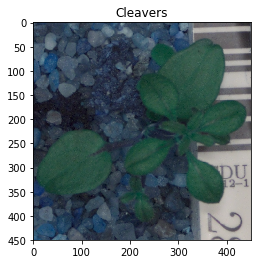

In [32]:
print("A few examples of images")

def plot_single_image(df, image_number):
    im = cv2.imread(df.loc[image_number, 'image'])
    plt.title(df.loc[image_number, 'target'])
    plt.imshow(im)
    
plot_single_image(images_df, 0)

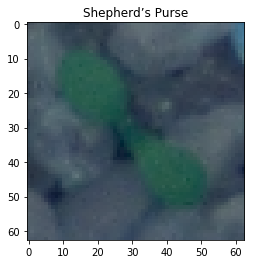

In [33]:
plot_single_image(images_df, 3000)

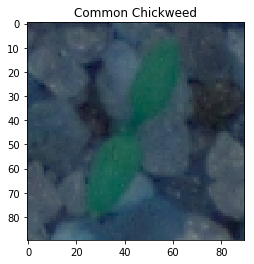

In [34]:
plot_single_image(images_df, 1000)

In [35]:
print("Examples of images for a few species")

def plot_for_class(df, label):
    # function plots 9 images
    nb_rows = 3
    nb_cols = 3
    
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df['target'] == label ]
            tmp.reset_index(drop=True, inplace=True)
            im = cv2.imread(tmp.loc[n, 'image'])          
            axs[i, j].imshow(im)
            n += 1 

Examples of images for a few species


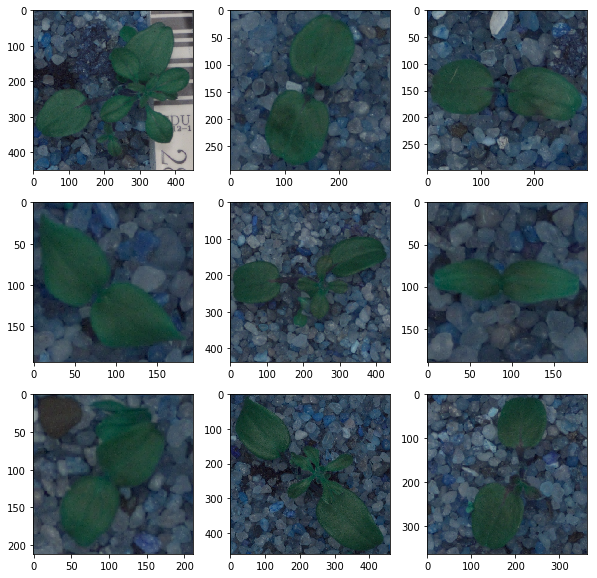

In [36]:
plot_for_class(images_df, 'Cleavers')

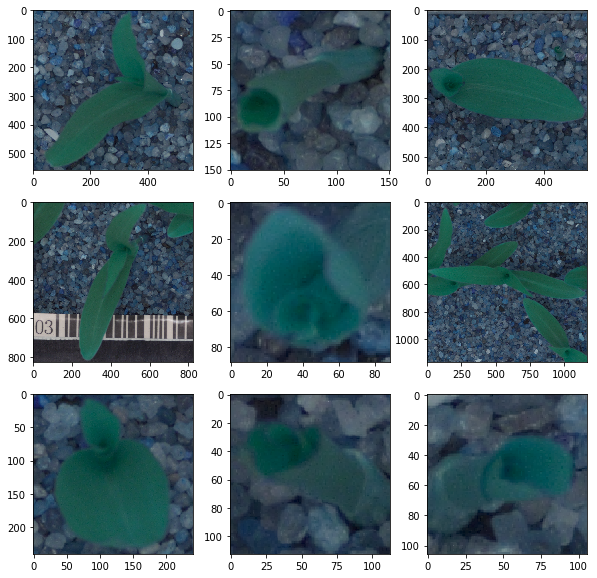

In [37]:
plot_for_class(images_df, 'Maize')

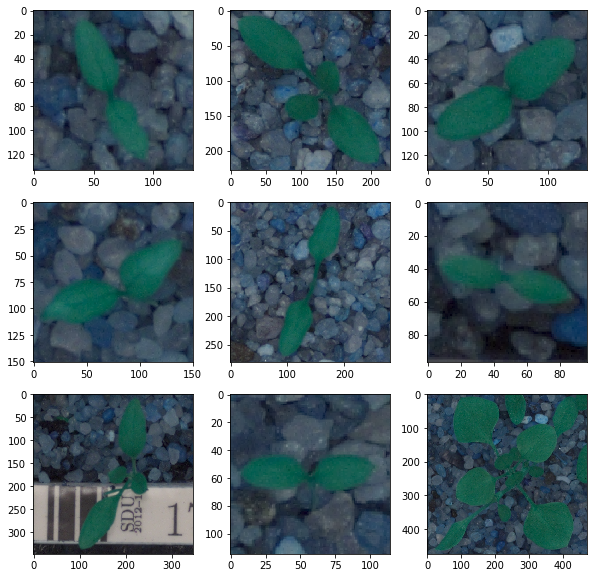

In [38]:
plot_for_class(images_df, 'Common Chickweed')

### Separate train and test

In [41]:
# train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_df['image'], images_df['target'], test_size=0.20, random_state=101)

print(f'Number of images in the trainning set: {X_train.shape[0]}')
print(f'Number of images in the testing set: {X_test.shape[0]}')

Number of images in the trainning set: 4431
Number of images in the testing set: 1108


In [42]:
# the indeces of the training data are mixed
# this will cause problems later

X_train.head()

1922    v2-plant-seedlings-dataset/Loose Silky-bent/24...
4164       v2-plant-seedlings-dataset/Black-grass/326.png
2952    v2-plant-seedlings-dataset/Shepherd’s Purse/14...
287            v2-plant-seedlings-dataset/Cleavers/93.png
4971          v2-plant-seedlings-dataset/Charlock/260.png
Name: image, dtype: object

In [43]:
# reset index

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_train.head()

0    v2-plant-seedlings-dataset/Loose Silky-bent/24...
1       v2-plant-seedlings-dataset/Black-grass/326.png
2    v2-plant-seedlings-dataset/Shepherd’s Purse/14...
3           v2-plant-seedlings-dataset/Cleavers/93.png
4          v2-plant-seedlings-dataset/Charlock/260.png
Name: image, dtype: object

In [44]:
# reset index in target as well

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [45]:
# percentage of images within each class

y_train.value_counts() / len(y_train)

Loose Silky-bent             0.137666
Common Chickweed             0.128639
Scentless Mayweed            0.108328
Small-flowered Cranesbill    0.104717
Fat Hen                      0.095689
Sugar beet                   0.083277
Charlock                     0.081471
Cleavers                     0.060934
Black-grass                  0.057323
Shepherd’s Purse             0.048070
Common wheat                 0.047168
Maize                        0.046716
Name: target, dtype: float64

In [46]:
# should be the same in the test set

y_test.value_counts() / len(y_test)

Loose Silky-bent             0.137184
Common Chickweed             0.129061
Scentless Mayweed            0.114621
Fat Hen                      0.102888
Small-flowered Cranesbill    0.101083
Sugar beet                   0.084838
Charlock                     0.082130
Cleavers                     0.058664
Shepherd’s Purse             0.055054
Black-grass                  0.049639
Maize                        0.045126
Common wheat                 0.039711
Name: target, dtype: float64

In [47]:
# Transform the target into categorical using one hot encoder

encoder = LabelEncoder()
encoder.fit(y_train)

train_y = np_utils.to_categorical(encoder.transform(y_train))
test_y = np_utils.to_categorical(encoder.transform(y_test))

train_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [48]:
# resize the image into 150 x 150

IMAGE_SIZE = 150

In [24]:
def im_resize(df, n):
    im = cv2.imread(df[n])
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    return im

In [25]:
tmp = im_resize(X_train, 7)
tmp.shape

(150, 150, 3)

In [49]:
# the shape of the datasets needs to be (n1, n2, n3, n4)
# where n1 is the number of observations
# n2 and n3 are image width and length
# and n4 indicates that it is a color image, so 3 planes (RGB) per image

def create_dataset(df, image_size):
    # reshape the data into desired size
    tmp = np.zeros((len(df), image_size, image_size, 3), dtype='float32')

    for n in range(0, len(df)):
        im = im_resize(df, n)
        tmp[n] = im
  
    print('Dataset Images shape: {} size: {:,}'.format(tmp.shape, tmp.size))
    return tmp

In [27]:
x_train = create_dataset(X_train, IMAGE_SIZE)

Dataset Images shape: (4431, 150, 150, 3) size: 299,092,500


In [28]:
x_test = create_dataset(X_test, IMAGE_SIZE)

Dataset Images shape: (1108, 150, 150, 3) size: 74,790,000


In [29]:
# number of different classes

len(y_train.unique())

12

In [ ]:
# Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

# Here is the CNN model

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation = "softmax"))

model.summary()

In [ ]:
# compile the model
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# specify batch size and number of epochs
batch_size = 10
epochs = 8

In [ ]:
# the path to save the trainned model
filepath = "model.h5"

# checkpoint to save the status of trainning
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, 
                             save_best_only=True, mode='max')

# learning rate reduce strategy
reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=1, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

# save the training into trainning
history = model.fit(x=x_train, y=train_y,
                    batch_size=batch_size, 
                    validation_split=10,
                    epochs=epochs,
                    verbose=2,
                    callbacks=callbacks_list)

In [ ]:
# visulize the trainning curve
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

In [ ]:
# make a prediction

predictions = model.predict_classes(x_test, verbose=1)

In [ ]:
# inspect predictions
predictions

In [ ]:
# transform target
encoder.transform(y_test)

In [ ]:
cnf_matrix = confusion_matrix(encoder.transform(y_test), predictions)

In [ ]:
# create a dict to map back the numbers onto the classes

tmp = pd.concat([y_test, pd.Series(encoder.transform(y_test))], axis=1)
tmp.columns = ['class_name', 'class_number']
tmp.drop_duplicates(inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp = pd.Series(tmp.class_name.values,index=tmp.class_number).to_dict()
tmp

In [ ]:
# these we will display in the below matrix
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
#fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

In [ ]:
accuracy_score(encoder.transform(y_test), predictions, normalize=True, sample_weight=None)

In [ ]:
print(classification_report(encoder.transform(y_test), predictions))